In [94]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns


def collect_data(model, method):
    # Directory containing the CSV files
    directory = f"outputs/results/{method}/{model}/"
    
    # Initialize an empty DataFrame to store all data
    combined_df = pd.DataFrame()
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Read each CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            
            # Determine index positions based on the model
            if "roberta" in model:
                lnum_ind = 3
            else: 
                lnum_ind = 2
            
            
            # Add lnum and lname columns
            df["lnum"] = df["parameter"].apply(lambda param: int(param.split(".")[lnum_ind]))
            df["lname"] = df["parameter"].apply(lambda param: param.split(".")[lnum_ind+1] + "." + param.split(".")[lnum_ind+2] + "." + param.split(".")[lnum_ind+3])
            
            # Append the data from this CSV to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    if method == "none":
        combined_df["rate"] = 0

    combined_df = combined_df.drop_duplicates(subset=['parameter', 'rate'])

    if method != "none":
        combined_df["accuracy_increase"] = combined_df["final_top1_accuracy"] - combined_df["edited_top1_accuracy"]
        combined_df["loss_change"] = combined_df["final_loss"] - combined_df["edited_loss"]

    sv_df = pd.read_csv(f"outputs/results/sv/{model}/sv.csv")

    df = pd.merge(combined_df, sv_df, on=["parameter", "rate"], how="left")

    df['final_perplexity'] = np.exp(df['final_loss'])
    df['edited_perplexity'] = np.exp(df['edited_loss'])

    df['lnum_over_spectral'] = df['lnum'] / df['diff_spectral_norm']
    df['lnum_over_frob'] = df['lnum'] / df['original_frobenius_norm']


    directory = f"outputs/results/none/{model}/"
    
    # Initialize an empty DataFrame to store all data
    combined_none_df = pd.DataFrame()
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Read each CSV file
            file_path = os.path.join(directory, filename)
            df_none = pd.read_csv(file_path)
            
            # Determine index positions based on the model
            if "roberta" in model:
                lnum_ind = 3
            else: 
                lnum_ind = 2
            
            # Add lnum and lname columns
            df_none["lnum"] = df_none["parameter"].apply(lambda param: int(param.split(".")[lnum_ind]))
            df_none["lname"] = df_none["parameter"].apply(lambda param: param.split(".")[lnum_ind+1] + "." + param.split(".")[lnum_ind+2] + "." + param.split(".")[lnum_ind+3])
            
            # Append the data from this CSV to the combined DataFrame
            combined_none_df = pd.concat([combined_none_df, df_none], ignore_index=True)

    df['final_change_from_reduction'] = np.nan
    df['final_change_from_reduction_ratio'] = np.nan
    df['edited_change_from_reduction'] = np.nan
    df['edited_change_from_reduction_ratio'] = np.nan

    df['improvement'] = df['final_top1_accuracy'] - df['edited_top1_accuracy']

    for i in range(len(df)):
        row = df.iloc[i, :]
        if row['rate'] != 0:

            # Make sure to use parentheses around each condition
            corresponding_row = combined_none_df[(combined_none_df['lname'] == row['lname']) & (combined_none_df['lnum'] == row['lnum'])]
            # Check if the corresponding_row exists
            if not corresponding_row.empty:
                #df.loc[i, 'final_change_from_reduction'] = row['final_top1_accuracy'] - corresponding_row['final_top1_accuracy'].values[0]
                #df.loc[i, 'final_change_from_reduction_ratio'] = (row['final_top1_accuracy'] - corresponding_row['final_top1_accuracy'].values[0]) / corresponding_row['final_top1_accuracy'].values[0]
                #df.loc[i, 'final_change_from_reduction'] = row['final_top1_accuracy'] - corresponding_row['final_top1_accuracy'].values[0]
                #df.loc[i, 'final_change_from_reduction_ratio'] = (row['final_top1_accuracy'] - corresponding_row['final_top1_accuracy'].values[0]) / corresponding_row['final_top1_accuracy'].values[0]
                df.loc[i, 'final_change_from_reduction'] = row['final_top10_accuracy'] - corresponding_row['final_top10_accuracy'].values[0]
                df.loc[i, 'final_change_from_reduction_ratio'] = (row['final_top10_accuracy'] - corresponding_row['final_top10_accuracy'].values[0]) / corresponding_row['final_top1_accuracy'].values[0]
            
    # Reorder columns to move 'lnum', 'lname', and 'rate' to the start
    columns_order = ['lnum', 'lname', 'rate'] + [col for col in df.columns if col not in ['lnum', 'lname', 'rate']]
    df = df[columns_order]


    
    return df

def print_layers(df):
    # Build the nested dictionary structure
    layers = {}

    for i in range(len(df)):
        rate = str(df.iloc[i, 2])
        transformer_block = df.iloc[i, 1]
        layer_number = df.iloc[i, 0]
        
        # Check if the rate key exists
        if rate not in layers:
            layers[rate] = {}
        
        # Check if the transformer block key exists within the rate
        if transformer_block not in layers[rate]:
            layers[rate][transformer_block] = {}
        
        # Assign the layer number within the transformer block
        layers[rate][transformer_block][layer_number] = "y"

    # Print the structure
    for r, r_val in layers.items():
        print(r)
        for b, b_val in r_val.items():
            print(f"   {b}")
            for l, l_val in b_val.items():
                print(f"       {l}")


def analyse_metrics(df, dependent_vars, independent_vars, separate_blocks = True):

    # Results storage
    analysis_results = []

    # Perform analysis separately for each transformer block and rate

    analysis_results = []

    if separate_blocks == True:
        grouped = df.groupby(['lname', 'rate'])

        for (block, rate), group in grouped:
            
            for dep_var in dependent_vars:
                for indep_var in independent_vars:

                    df = compute_metrics(group, dep_var, indep_var, rate, block)
                    analysis_results.append(df)

    else:
        grouped = df.groupby(['rate'])
        for rate, group in grouped:
            
            for dep_var in dependent_vars:
                for indep_var in independent_vars:
                    df = compute_metrics(group, dep_var, indep_var, rate, "all")
                    analysis_results.append(df)

    # Convert results to DataFrame
    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv("detailed_analysis_results.csv", index=False)
    
    return results_df

def compute_metrics(group, dep_var, indep_var, rate, block):

    # Initialize result dictionary
    result = {
        'transformer_block': block,
        'rate': rate,
        'dependent_variable': dep_var,
        'independent_variable': indep_var,
    }
    
    try:
        # Calculate correlations
        pearson_corr, pearson_pval = pearsonr(group[indep_var], group[dep_var])
        spearman_corr, spearman_pval = spearmanr(group[indep_var], group[dep_var])
        kendall_corr, kendall_pval = kendalltau(group[indep_var], group[dep_var])
        
        result.update({
            'pearson_corr': pearson_corr,
            'spearman_corr': spearman_corr,
            'kendall_tau': kendall_corr,
            'pearson_pval': pearson_pval,
            'spearman_pval': spearman_pval,
            'kendall_pval': kendall_pval
        })

        
        """
        if "perplexity" in dep_var:
            # Ranking-Based Method
            best_layer_idx = group[dep_var].idxmin()
        else: 
            best_layer_idx = group[dep_var].idxmax()

        best_layer_num = group.loc[best_layer_idx, "lnum"]
        best_layer_block = group.loc[best_layer_idx, "lname"]
        best_performance = group.loc[best_layer_idx, dep_var]
        
        min_metric_idx = group[indep_var].idxmin()
        max_metric_idx = group[indep_var].idxmax()
        
        min_metric_performance = group.loc[min_metric_idx, dep_var]
        max_metric_performance = group.loc[max_metric_idx, dep_var]

        if "perplexity" in dep_var:
            if min_metric_performance < max_metric_performance:
                selected_performance = min_metric_performance
                select_by = "min"
                selected_layer_num = group.loc[min_metric_idx, "lnum"]
                selected_layer_block = group.loc[min_metric_idx, "lname"]
            else:
                selected_performance = max_metric_performance
                select_by = "max"
                selected_layer_num = group.loc[max_metric_idx, "lnum"]
                selected_layer_block = group.loc[max_metric_idx, "lname"]

        else:
            if min_metric_performance > max_metric_performance:
                selected_performance = min_metric_performance
                select_by = "min"
                selected_layer_num = group.loc[min_metric_idx, "lnum"]
                selected_layer_block = group.loc[min_metric_idx, "lname"]
            else:
                selected_performance = max_metric_performance
                select_by = "max"
                selected_layer_num = group.loc[max_metric_idx, "lnum"]
                selected_layer_block = group.loc[max_metric_idx, "lname"]


        mean_performance = group[dep_var].mean()
        
        result.update({
            'best_layer_num': best_layer_num,
            'best_layer_block': best_layer_block,
            'mean_performance': mean_performance,
            "best_performance": best_performance,
            'selected_layer_num': selected_layer_num,
            'selected_layer_block': selected_layer_block,
            'select_by': select_by,
            "selected_performance": selected_performance,
            'performance_decrease_from_best': best_performance - selected_performance,
            'performance_increase_from_mean': selected_performance - mean_performance,
        })

        """

    except Exception as e:
        err = 1
        #print(f"Error with {dep_var} vs {indep_var}: {e}")

    return result

def plot_metrics():
    pass

In [66]:
independent_vars = [
    'lnum', 'norm', 'relative_error_x', 'original_frobenius_norm',
    'original_spectral_norm', 'original_nuclear_norm', 
    'original_condition_number', 'original_shannon_entropy',
    'diff_frobenius_norm', 'diff_spectral_norm', 'diff_nuclear_norm', 
    'diff_condition_number', 'diff_shannon_entropy', 'energy_retained'
]

dependent_vars = [
    'edited_top1_accuracy', 'edited_perplexity', 'edited_top10_accuracy',
    'final_top1_accuracy', 'final_perplexity', 'final_top10_accuracy', 'perplexity'
]



independent_vars = [
    'lnum'
]

dependent_vars = [
    'final_top1_accuracy', 'final_perplexity'
]


In [67]:
df = collect_data("roberta_base", "lr")
#print_layers(df)
results_df = analyse_metrics(df, dependent_vars, independent_vars, True)

In [68]:
df

,lnum,lname,rate,original_loss,original_top1_accuracy,original_top10_accuracy,original_top1_words,original_top10_words,parameter,dataset_len,...,diff_shannon_entropy,frobenius_diff_norm,relative_error_y,energy_retained,final_perplexity,edited_perplexity,final_change_from_reduction,final_change_from_reduction_ratio,edited_change_from_reduction,edited_change_from_reduction_ratio
0,0,attention.output.dense,0.8,0.090769,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.0.attention.output.dense...,65757,...,6.160095,16.014713,0.544356,0.703674,1.021634,1.097553,-0.066001,-0.089201,NaN,NaN
1,0,attention.output.dense,0.8,0.090769,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.0.attention.output.dense...,65757,...,6.160095,16.014713,0.544356,0.703674,1.021634,1.097553,-0.066001,-0.089201,NaN,NaN
2,1,attention.output.dense,0.8,0.090769,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.1.attention.output.dense...,65757,...,6.137882,15.792068,0.541053,0.707260,1.024383,1.097439,-0.032270,-0.048837,NaN,NaN
3,1,attention.output.dense,0.8,0.090769,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.1.attention.output.dense...,65757,...,6.137882,15.792068,0.541053,0.707260,1.024383,1.097439,-0.032270,-0.048837,NaN,NaN
4,2,attention.output.dense,0.8,0.090769,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.2.attention.output.dense...,65757,...,6.144521,17.713541,0.577138,0.666909,1.024964,1.094272,-0.043493,-0.065847,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,6,intermediate.dense.weight,0.9,0.181046,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.6.intermediate.dense.weight,65757,...,6.477624,70.444199,0.815397,0.335108,1.028897,1.216165,-0.121995,-0.133478,NaN,NaN
161,7,intermediate.dense.weight,0.9,0.181046,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.7.intermediate.dense.weight,65757,...,6.480977,71.553368,0.821640,0.324887,1.029684,1.207428,-0.127196,-0.139833,NaN,NaN
162,8,intermediate.dense.weight,0.9,0.181046,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.8.intermediate.dense.weight,65757,...,6.485186,68.906189,0.811905,0.340800,1.020111,1.206100,-0.052040,-0.056567,NaN,NaN
163,10,output.dense.weight,0.9,0.181046,0.173586,0.388002,"{'common_nouns': 457, 'proper_nouns': 11001, '...","{'common_nouns': 635, 'proper_nouns': 10320, '...",roberta.encoder.layer.10.output.dense.weight,65757,...,6.478363,53.623020,0.850855,0.276020,1.040574,1.198124,-0.095381,-0.122066,NaN,NaN


In [69]:
results_df

,transformer_block,rate,dependent_variable,independent_variable,pearson_corr,spearman_corr,kendall_tau,pearson_pval,spearman_pval,kendall_pval,best_layer_num,best_layer_block,mean_performance,best_performance,selected_layer_num,selected_layer_block,select_by,selected_performance,performance_decrease_from_best,performance_increase_from_mean
0,attention.output.dense,0.8,final_top1_accuracy,lnum,-0.807242,-0.706294,-0.545455,1.870204e-06,1.147494e-04,3.207786e-04,0,attention.output.dense,0.592174,0.673905,0,attention.output.dense,min,0.673905,0.000000,0.081731
1,attention.output.dense,0.8,final_perplexity,lnum,0.740922,0.510490,0.363636,3.455211e-05,1.080732e-02,1.645744e-02,0,attention.output.dense,1.026576,1.021634,0,attention.output.dense,min,1.021634,0.000000,-0.004942
2,attention.output.dense,0.9,final_top1_accuracy,lnum,-0.860641,-0.909091,-0.818182,6.864372e-08,7.892850e-10,6.781262e-08,0,attention.output.dense,0.577633,0.635750,0,attention.output.dense,min,0.635750,0.000000,0.058117
3,attention.output.dense,0.9,final_perplexity,lnum,0.781277,0.839161,0.727273,6.590974e-06,2.990592e-07,1.608830e-06,0,attention.output.dense,1.056014,1.048786,0,attention.output.dense,min,1.048786,0.000000,-0.007228
4,attention.self.key,0.8,final_top1_accuracy,lnum,-0.503812,-0.400000,-0.309091,1.140926e-01,2.228684e-01,2.183465e-01,3,attention.self.key,0.458816,0.508919,0,attention.self.key,min,0.448561,0.060359,-0.010255
5,attention.self.key,0.8,final_perplexity,lnum,0.629734,0.590909,0.490909,3.785838e-02,5.557560e-02,4.053236e-02,3,attention.self.key,1.086467,1.073613,0,attention.self.key,min,1.087194,-0.013582,0.000727
6,attention.self.key,0.9,final_top1_accuracy,lnum,-0.594784,-0.580420,-0.363636,4.135892e-02,4.785598e-02,1.159509e-01,3,attention.self.key,0.436378,0.480816,0,attention.self.key,min,0.413036,0.067780,-0.023342
7,attention.self.key,0.9,final_perplexity,lnum,0.696931,0.601399,0.424242,1.177700e-02,3.858845e-02,6.286915e-02,4,attention.self.key,1.091637,1.078903,0,attention.self.key,min,1.094918,-0.016015,0.003281
8,attention.self.query,0.8,final_top1_accuracy,lnum,-0.858776,-0.700000,-0.490909,7.108776e-04,1.647098e-02,4.053236e-02,3,attention.self.query,0.452660,0.514151,0,attention.self.query,min,0.470140,0.044011,0.017480
9,attention.self.query,0.8,final_perplexity,lnum,0.854260,0.727273,0.563636,8.134609e-04,1.120497e-02,1.654050e-02,3,attention.self.query,1.088466,1.072195,0,attention.self.query,min,1.082752,-0.010557,-0.005713


In [70]:
print(results_df)

            transformer_block  rate   dependent_variable independent_variable  \
0      attention.output.dense   0.8  final_top1_accuracy                 lnum   
1      attention.output.dense   0.8     final_perplexity                 lnum   
2      attention.output.dense   0.9  final_top1_accuracy                 lnum   
3      attention.output.dense   0.9     final_perplexity                 lnum   
4          attention.self.key   0.8  final_top1_accuracy                 lnum   
5          attention.self.key   0.8     final_perplexity                 lnum   
6          attention.self.key   0.9  final_top1_accuracy                 lnum   
7          attention.self.key   0.9     final_perplexity                 lnum   
8        attention.self.query   0.8  final_top1_accuracy                 lnum   
9        attention.self.query   0.8     final_perplexity                 lnum   
10       attention.self.query   0.9  final_top1_accuracy                 lnum   
11       attention.self.quer

In [71]:
for i in range(len(results_df)):
    print(results_df.iloc[i,:])

transformer_block                 attention.output.dense
rate                                                 0.8
dependent_variable                   final_top1_accuracy
independent_variable                                lnum
pearson_corr                                   -0.807242
spearman_corr                                  -0.706294
kendall_tau                                    -0.545455
pearson_pval                                    0.000002
spearman_pval                                   0.000115
kendall_pval                                    0.000321
best_layer_num                                         0
best_layer_block                  attention.output.dense
mean_performance                                0.592174
best_performance                                0.673905
selected_layer_num                                     0
selected_layer_block              attention.output.dense
select_by                                            min
selected_performance           

In [106]:
def generate_analysis_tables(models, dependent_vars, independent_vars):
    # Initialize a dictionary to store the tables for each dependent variable
    tables = {dep_var: pd.DataFrame() for dep_var in dependent_vars}

    # Iterate over each model
    for model in models:
        # Collect data for the model
        df = collect_data(model, method="lr")

        # Filter for rate 0.8
        df = df[df['rate'] == 0.8]

        # Analyze metrics
        results_df = analyse_metrics(df, dependent_vars, independent_vars, separate_blocks=True)

        # Iterate over each dependent variable to create the tables
        for dep_var in dependent_vars:
            # Initialize a list to collect the data for each transformer block
            model_data = []

            # Filter the results for the current dependent variable
            filtered_df = results_df[results_df['dependent_variable'] == dep_var]

            # Iterate over each block in the filtered_df
            for block in filtered_df['transformer_block'].unique():
                # Filter for the current block
                block_df = filtered_df[filtered_df['transformer_block'] == block]

                # Create a series with independent variables as index and performance decreases as values
                performance_decreases = pd.Series({
                    indep_var: block_df[block_df['independent_variable'] == indep_var]['pearson_corr'].values[0]
                    for indep_var in independent_vars
                })

                # Append the performance decreases with the block as index
                model_data.append(performance_decreases)

            # Convert the list of series to a DataFrame
            model_table = pd.DataFrame(model_data)

            # Set the index of the model's table to the block names
            model_table.index = filtered_df['transformer_block'].unique()

            # Add the model's table to the corresponding dependent variable's table
            tables[dep_var] = pd.concat([tables[dep_var], model_table], axis=0)

    return tables

# Define models and dependent variables of interest
models = ["roberta_base", "pythia160m", "pythia410m"]

independent_vars = [
    'lnum', 'norm', 'relative_error_x', 'original_frobenius_norm',
    'original_spectral_norm', 'original_nuclear_norm', 
    'original_condition_number', 'original_shannon_entropy',
    'diff_frobenius_norm', 'diff_spectral_norm', 'diff_nuclear_norm', 
    'diff_condition_number', 'diff_shannon_entropy', 'energy_retained'
]


dependent_vars_of_interest = [
    'final_top1_accuracy', 'final_perplexity', 
    'edited_top1_accuracy', 'edited_perplexity', 
    'final_change_from_reduction', 'final_change_from_reduction_ratio',
]

# Generate the tables
analysis_tables = generate_analysis_tables(models, dependent_vars_of_interest, independent_vars)

# Display the generated tables for each dependent variable
for dep_var, table in analysis_tables.items():
    print(f"\nAnalysis Table for {dep_var}:\n")
    print(table)

    # Optionally, save each table to a CSV file
    table.to_csv(f"{dep_var}_analysis_table.csv", index=True)



Analysis Table for final_top1_accuracy:

                                      lnum      norm  relative_error_x  \
attention.output.dense           -0.807242 -0.762842         -0.620801   
attention.self.key               -0.503812  0.009235          0.464160   
attention.self.query             -0.858776  0.362755          0.753965   
attention.self.value             -0.728765 -0.844691         -0.481026   
intermediate.dense.weight        -0.449973  0.466066         -0.013163   
output.dense.weight              -0.441218  0.881291         -0.022255   
attention.dense.weight           -0.935945 -0.451142         -0.293884   
attention.query_key_value.weight -0.863671 -0.189798          0.622046   
mlp.dense_4h_to_h.weight         -0.951153 -0.784864          0.267066   
mlp.dense_h_to_4h.weight         -0.861998  0.426265          0.253316   
attention.dense.weight           -0.884566 -0.145049         -0.226855   
attention.query_key_value.weight -0.843525 -0.480260          0.761039

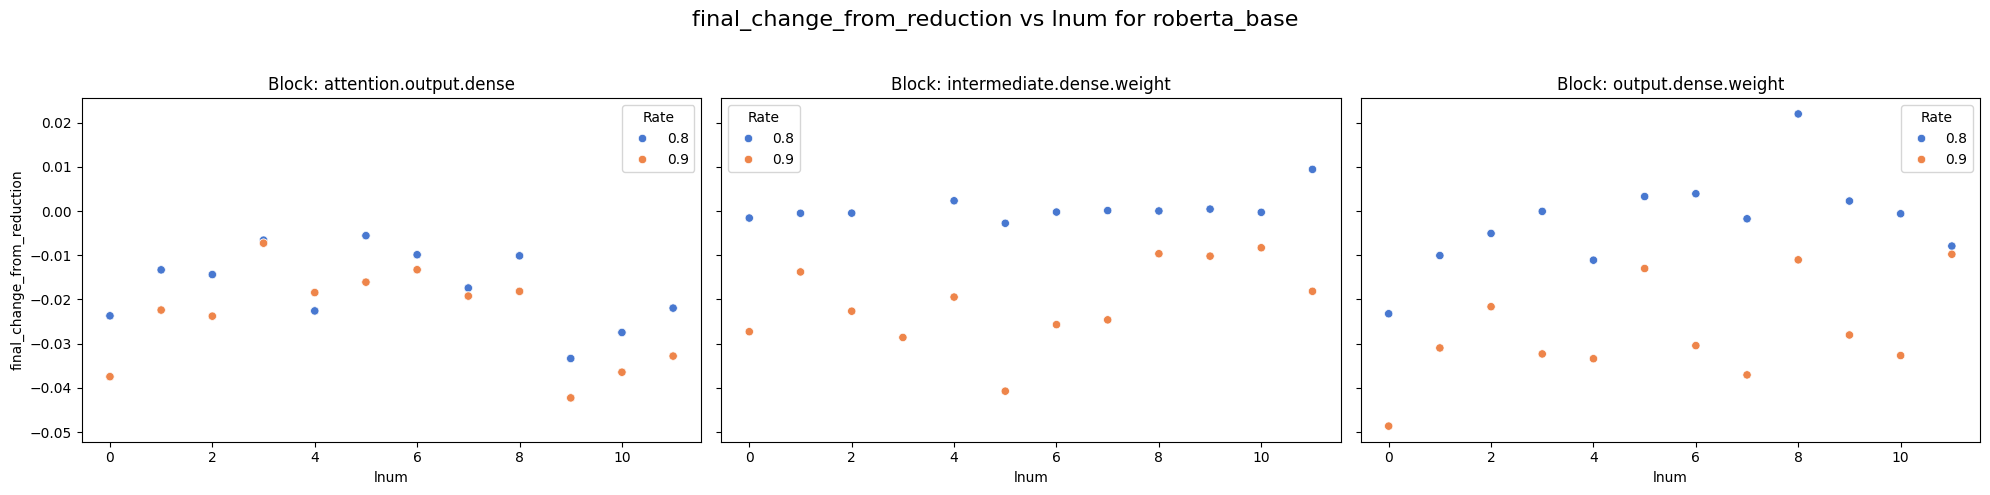

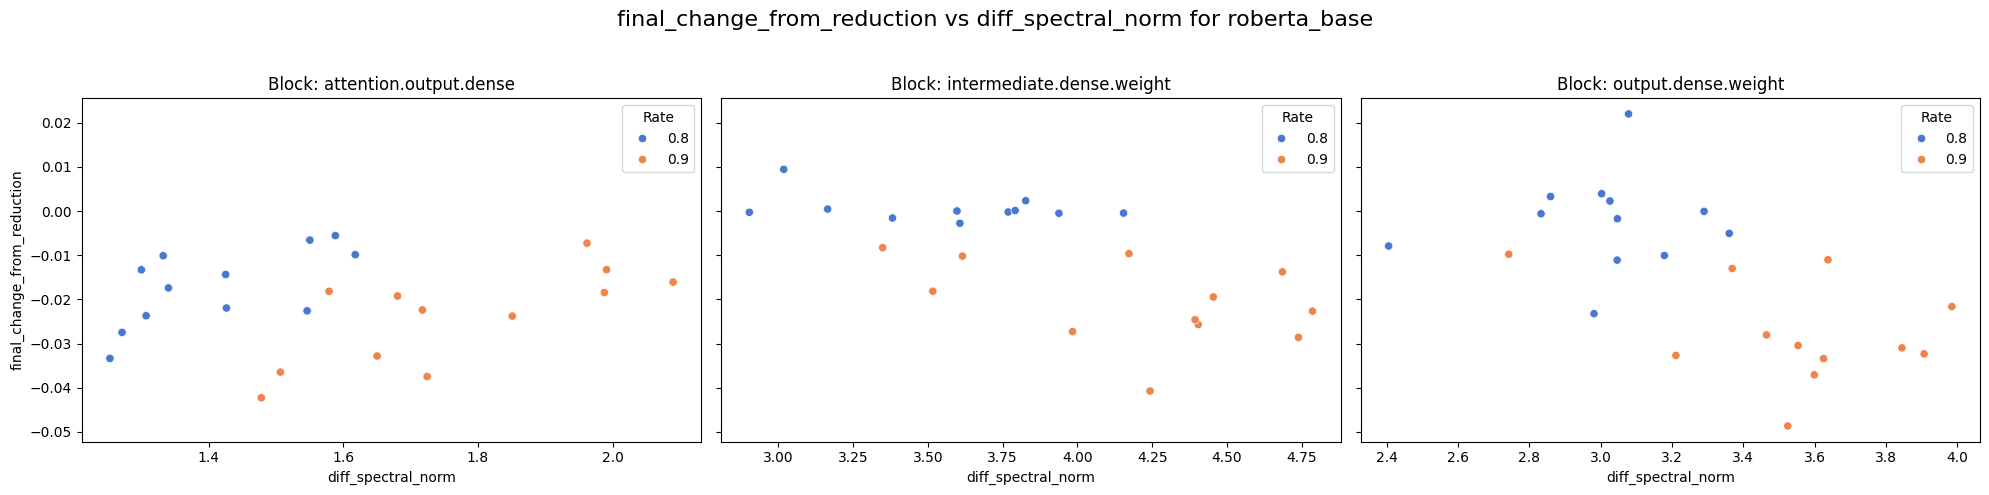

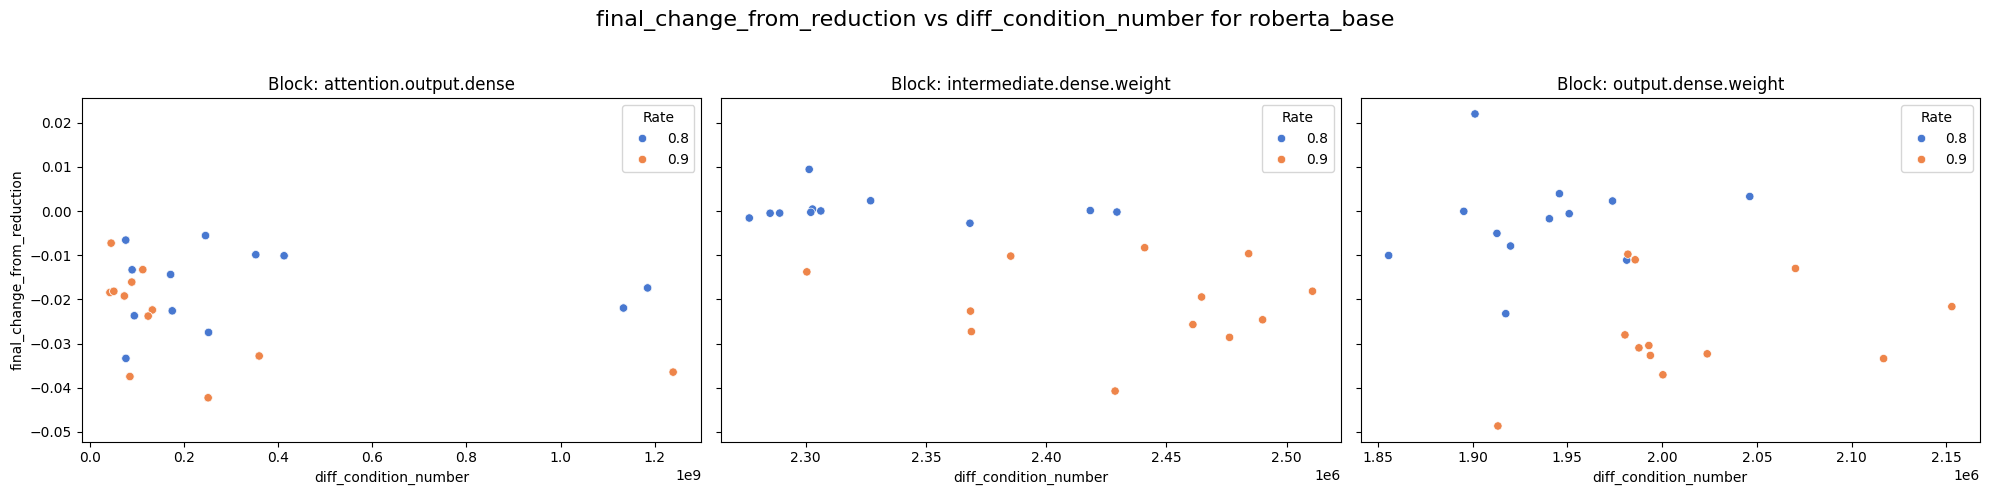

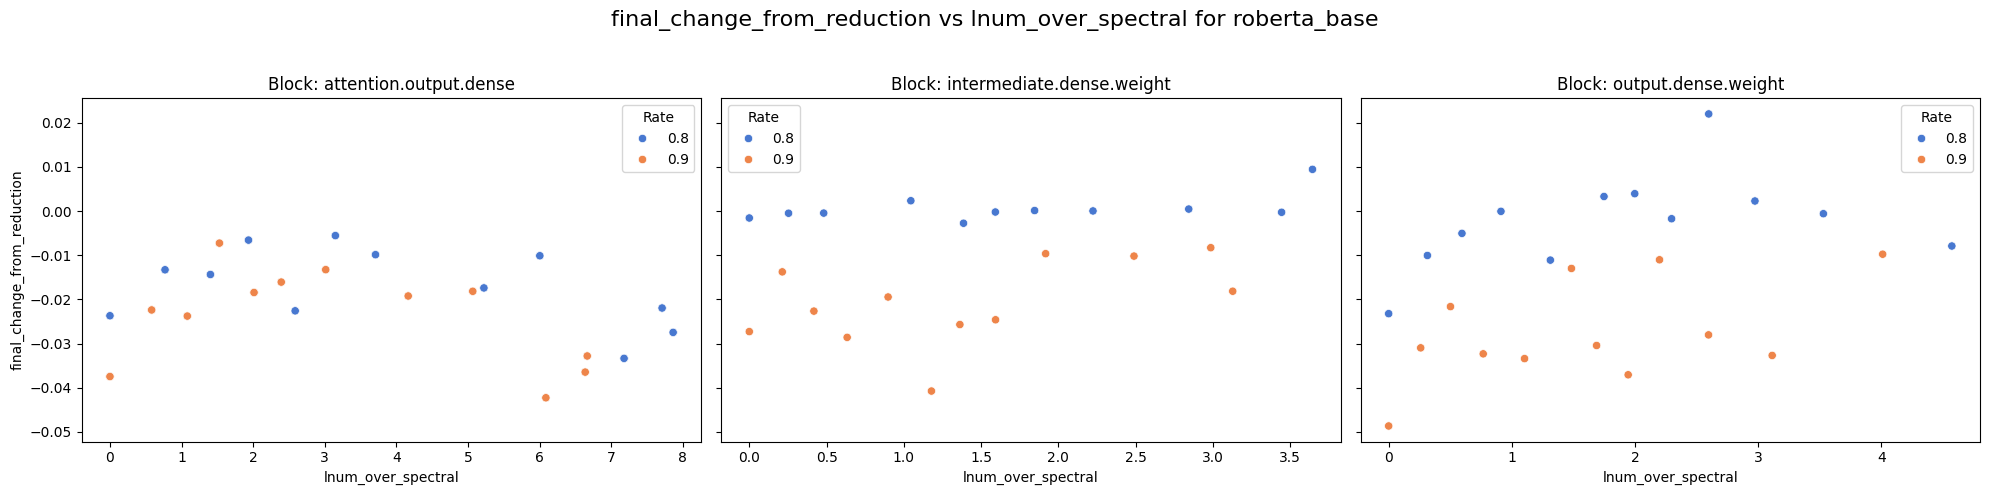

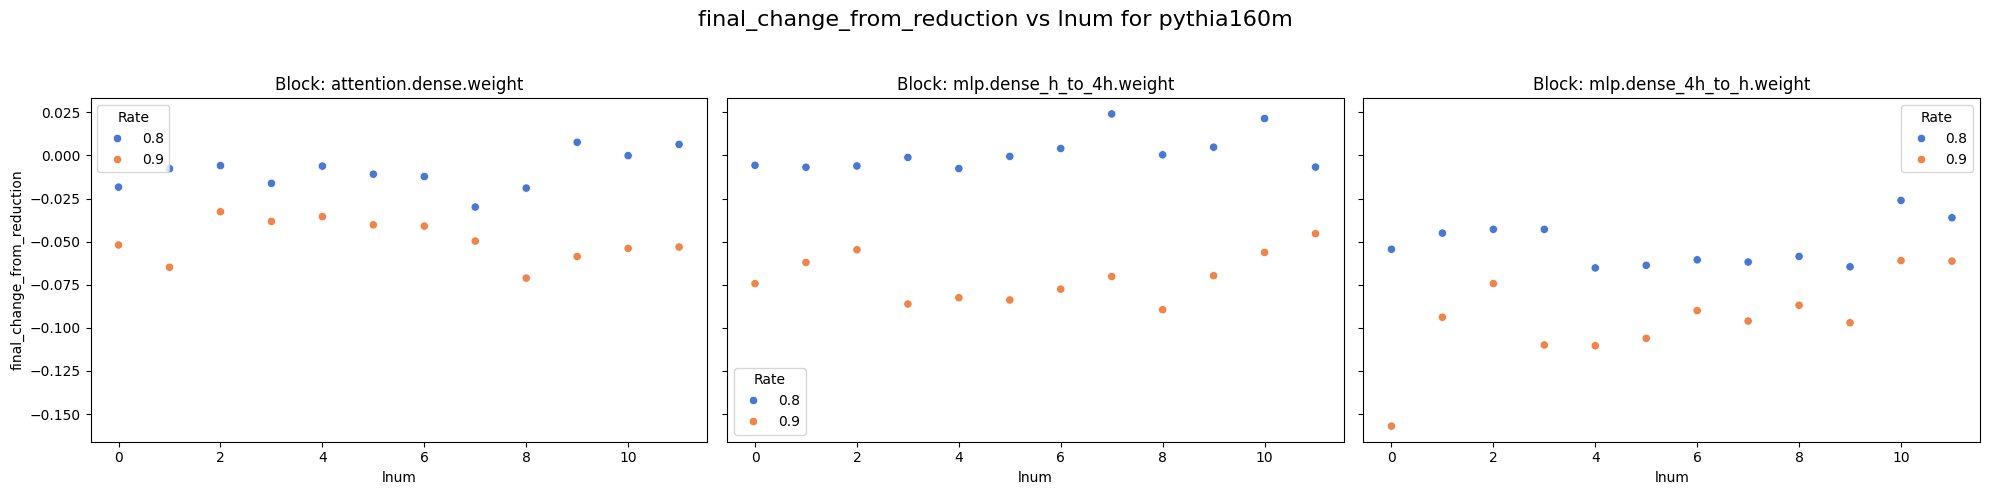

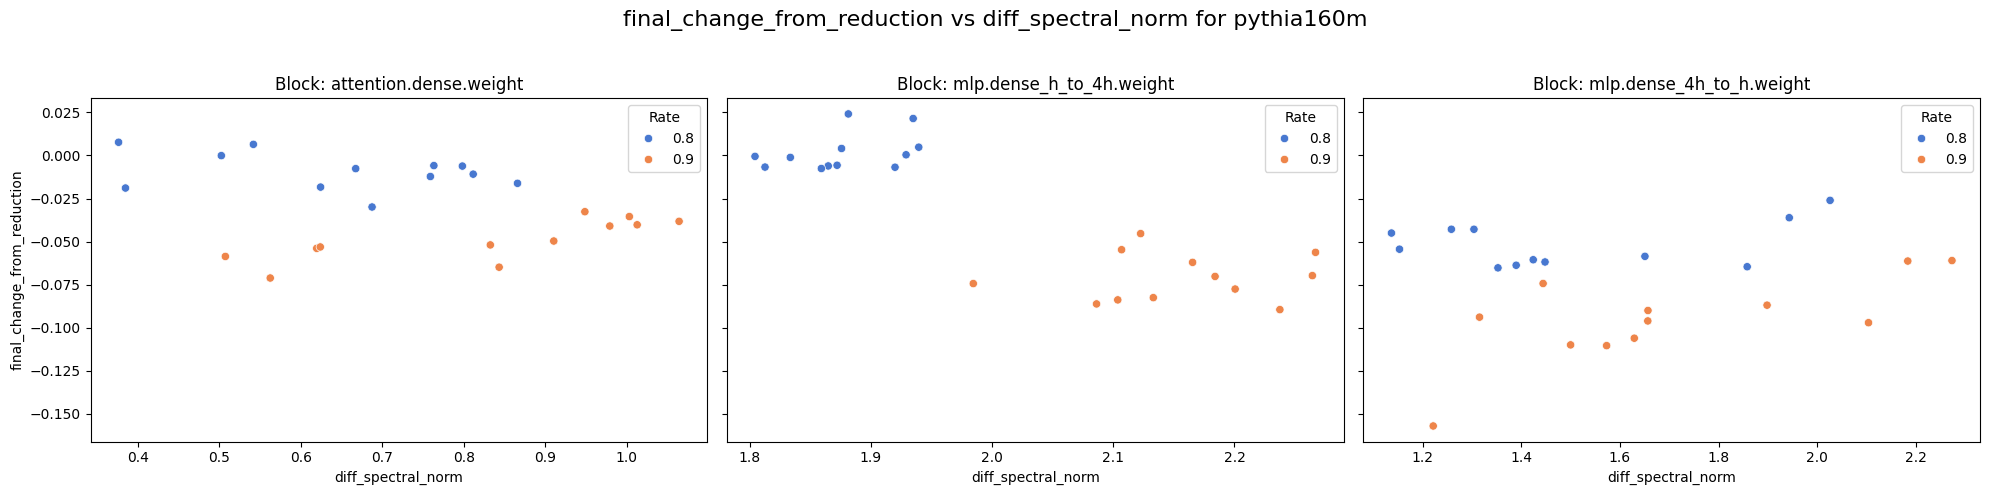

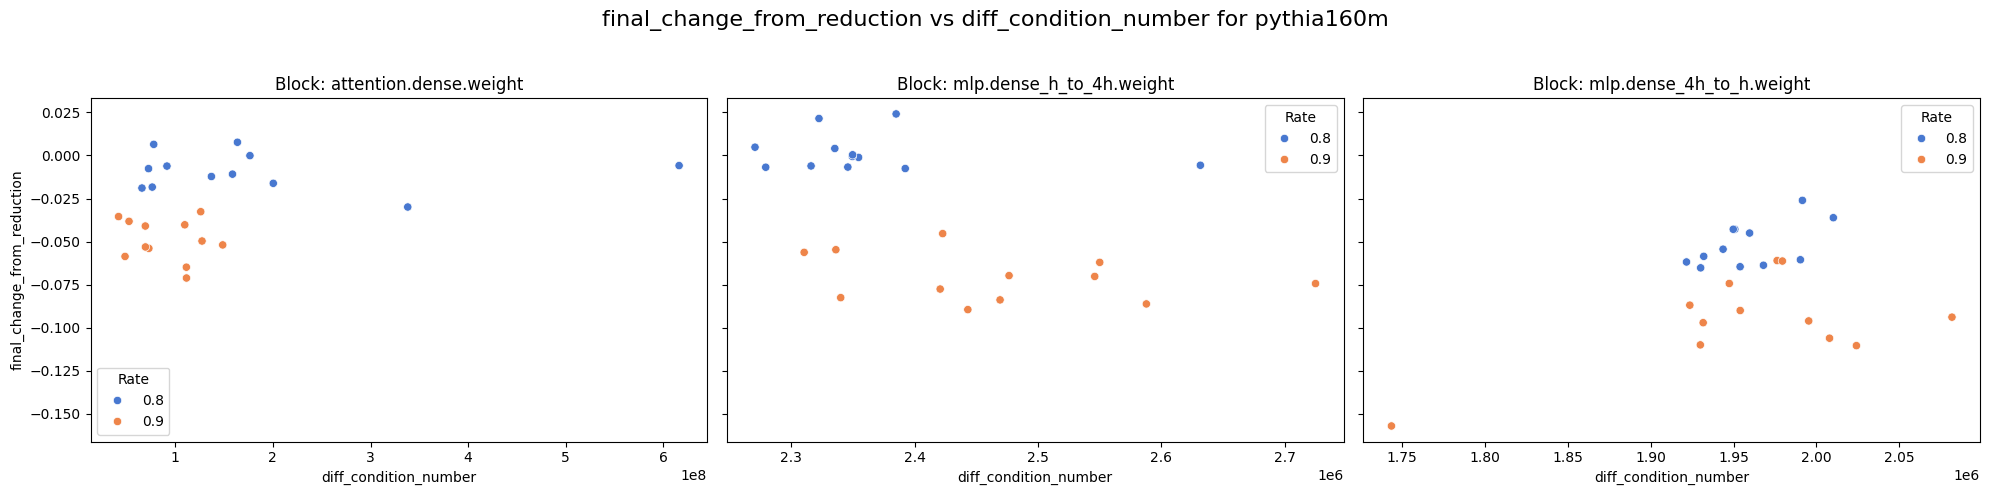

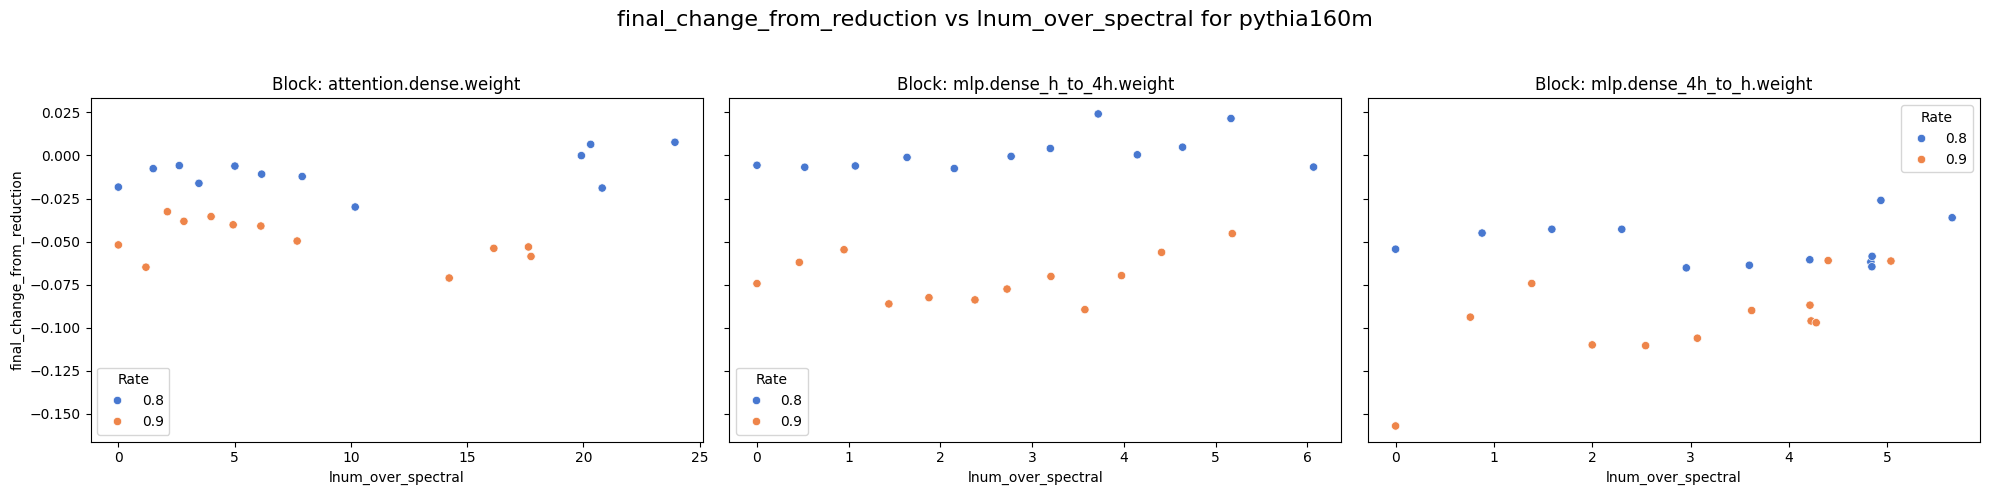

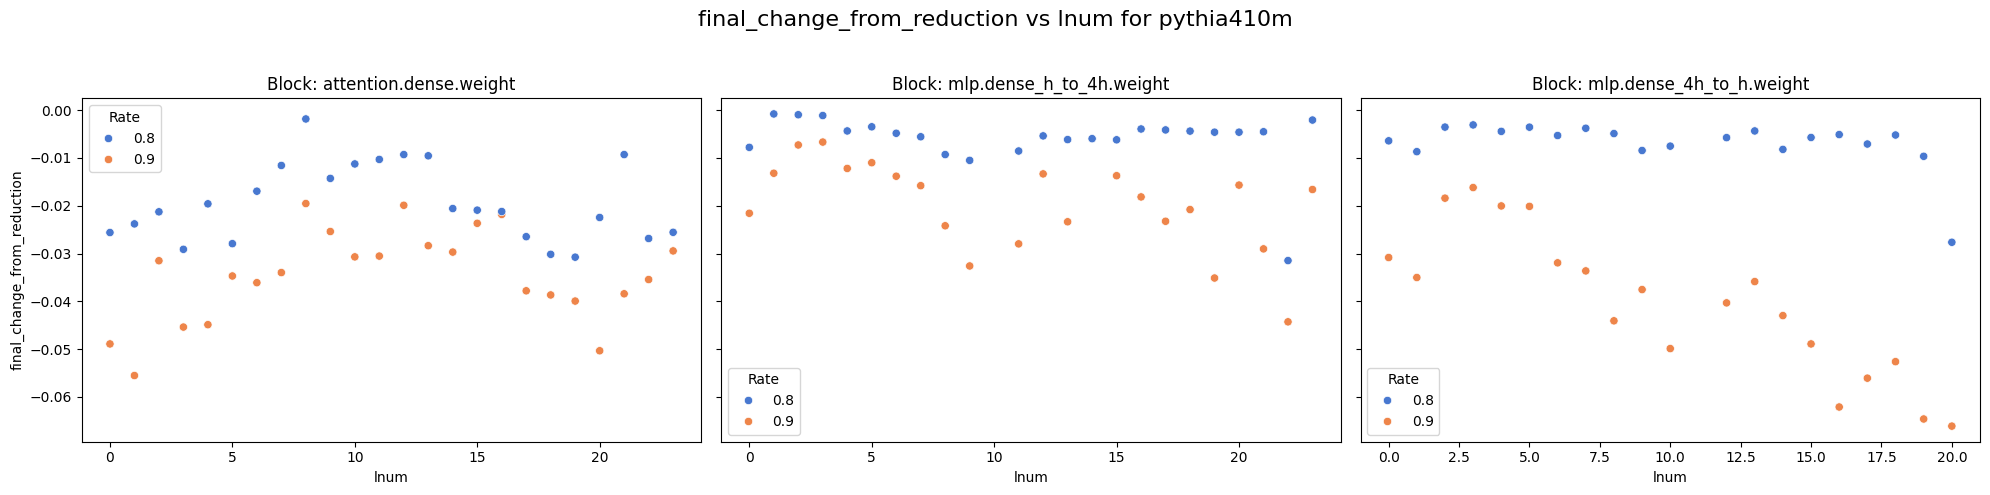

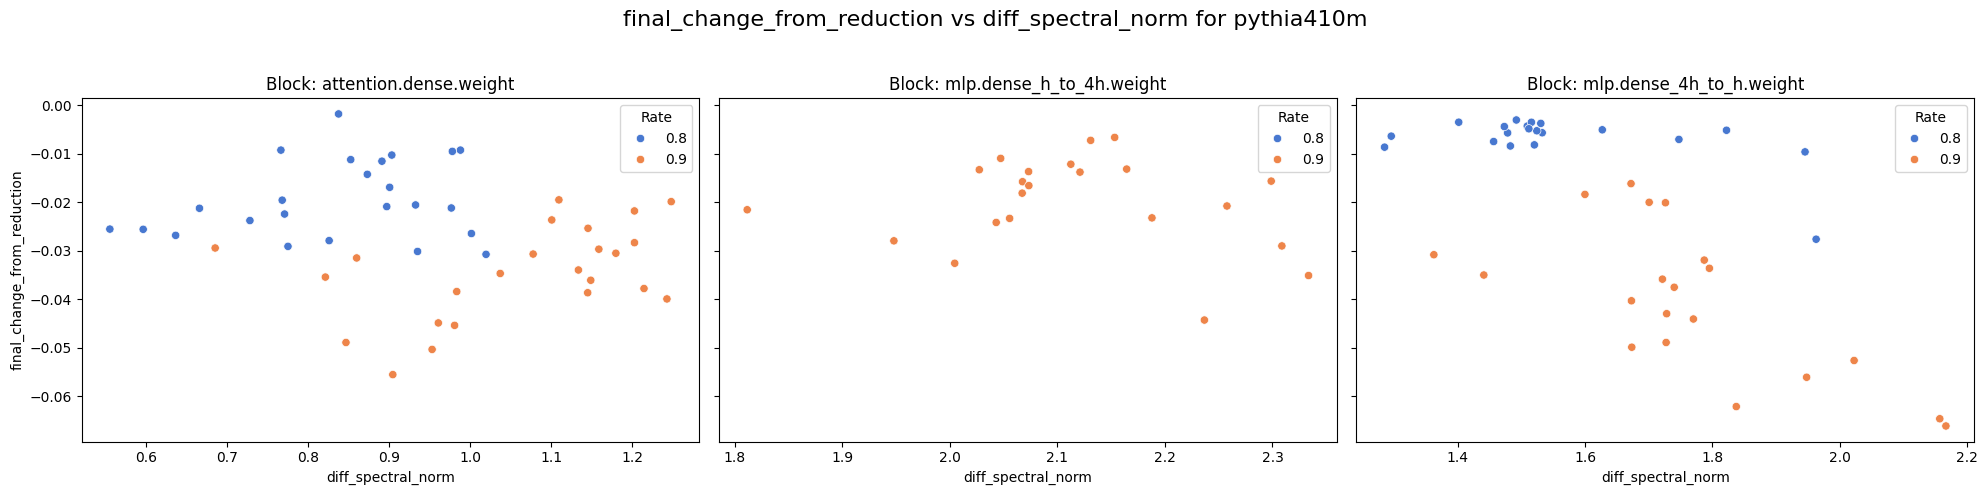

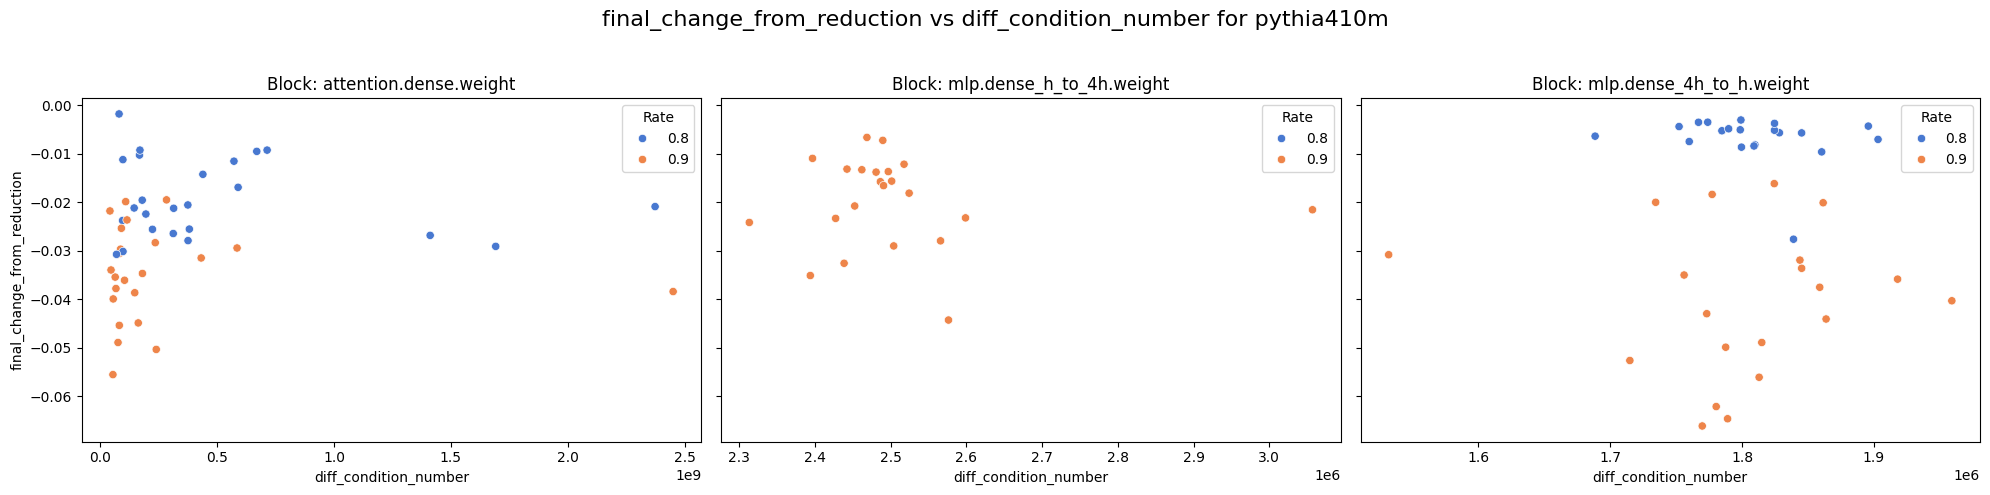

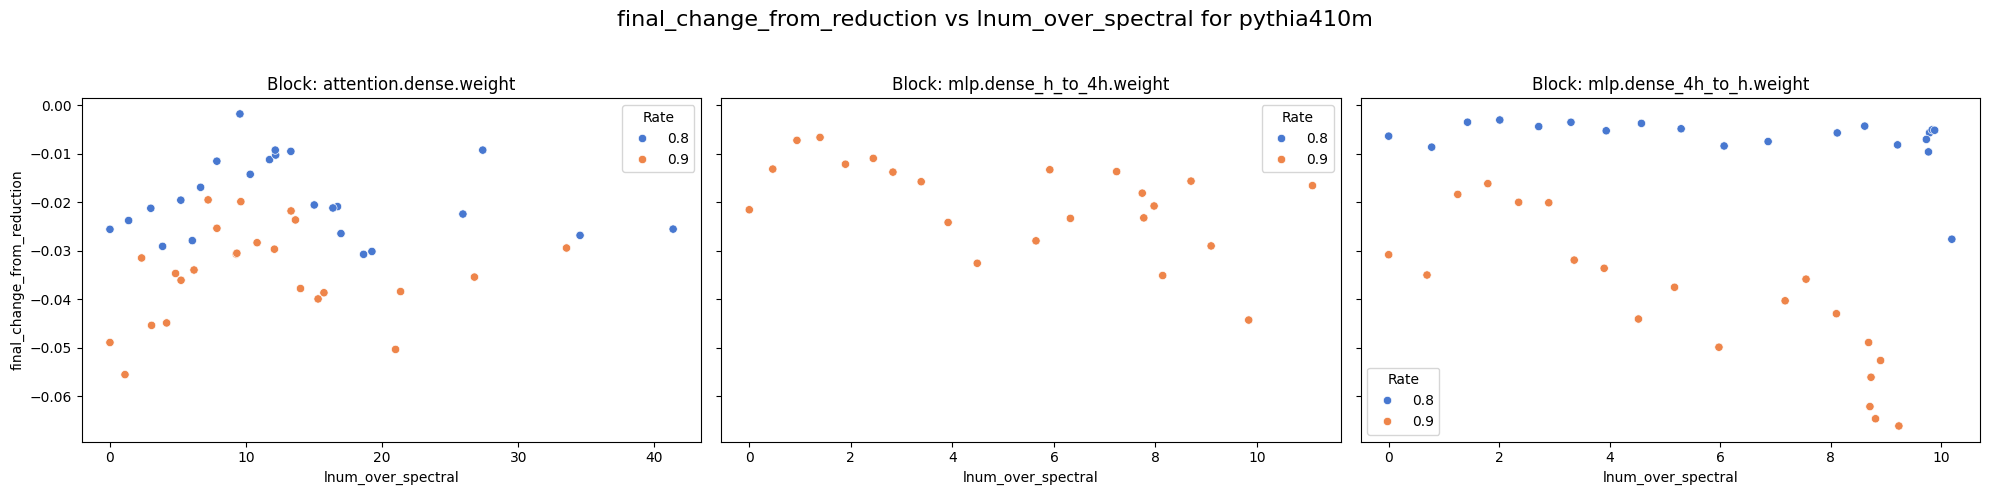

In [111]:
def plot_metrics(df, model_name, dependent_vars, independent_vars):
    # Get unique transformer blocks
    blocks_df = df['lname'].unique()

    sorted_blocks = ['attention.query_key_value.weight',
              'attention.dense.weight',
              'mlp.dense_h_to_4h.weight',
              'mlp.dense_4h_to_h.weight',
              'attention.self.key.weight',
              'attention.self.query',
              'attention.self.value',
              'attention.output.dense',
              'intermediate.dense.weight',
              'output.dense.weight'
              ]
    
    sorted_blocks = [
              'attention.dense.weight',
              'mlp.dense_h_to_4h.weight',
              'mlp.dense_4h_to_h.weight',
              'attention.output.dense',
              'intermediate.dense.weight',
              'output.dense.weight'
              ]
    
    blocks = []
    
    for b in sorted_blocks:
        if b in blocks_df:
            blocks.append(b)

    # Iterate over each combination of dependent and independent variables
    for dep_var in dependent_vars:
        for indep_var in independent_vars:
            # Create subplots for each transformer block
            fig, axes = plt.subplots(nrows=1, ncols=len(blocks), figsize=(20, 5), sharey=True)
            fig.suptitle(f'{dep_var} vs {indep_var} for {model_name}', fontsize=16)

            # Iterate over each block to create the subplot
            for i, block in enumerate(blocks):
                ax = axes[i]
                block_df = df[df['lname'] == block]

                # Plot the data
                sns.scatterplot(
                    x=block_df[indep_var],
                    y=block_df[dep_var],
                    hue=block_df['rate'],
                    palette='muted',
                    ax=ax
                )

                ax.set_title(f'Block: {block}')
                ax.set_xlabel(indep_var)
                ax.set_ylabel(dep_var)
                ax.legend(title='Rate')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()


def plot_relationships(df, independent_vars, dependent_vars):

    """
    Plots the relationship between independent and dependent variables without separating into blocks.

    Args:
    - df (pd.DataFrame): The dataframe containing the data.
    - independent_vars (list): A list of independent variables to plot.
    - dependent_vars (list): A list of dependent variables to plot.
    - model_name (str): The name of the model, used for the plot title.
    """

    num_independent_vars = len(independent_vars)
    num_dependent_vars = len(dependent_vars)

    df = df[df["rate"] == 0.8]
    
    fig, axes = plt.subplots(num_dependent_vars, num_independent_vars, figsize=(5 * num_independent_vars, 4 * num_dependent_vars))

    # Flatten axes array if there's more than one subplot
    if num_independent_vars > 1 or num_dependent_vars > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    plot_idx = 0
    for dep_var in dependent_vars:
        for indep_var in independent_vars:
            ax = axes[plot_idx]
            sns.scatterplot(x=indep_var, y=dep_var, data=df, ax=ax, hue="lname")
            ax.set_title(f'{dep_var} vs {indep_var}')
            ax.set_xlabel(indep_var)
            ax.set_ylabel(dep_var)
            plot_idx += 1

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Define the models, dependent variables, and independent variables
models = ["roberta_base", "pythia160m", "pythia410m"]

dependent_vars = [
    'final_top1_accuracy', 'final_perplexity', 
    'edited_top1_accuracy', 'edited_perplexity', 
    'final_change_from_reduction', 'final_change_from_reduction_ratio',
]


independent_vars = [
    'lnum', 'norm', 'relative_error_x', 
    'original_spectral_norm', 'original_nuclear_norm', 'original_shannon_entropy',
    'diff_frobenius_norm', 'diff_nuclear_norm', 'diff_shannon_entropy', 'energy_retained'
]

#models = ["pythia160m"]

independent_vars = [
    'lnum', 'norm', 'relative_error_x', 'original_frobenius_norm',
    'original_spectral_norm', 'original_nuclear_norm', 
    'original_condition_number', 'original_shannon_entropy',
    'diff_frobenius_norm', 'diff_spectral_norm', 'diff_nuclear_norm', 
    'diff_condition_number', 'diff_shannon_entropy', 'energy_retained', 'lnum_over_spectral'
]



dependent_vars = [
    'final_change_from_reduction'
]

independent_vars = [
    'lnum', 'diff_spectral_norm', 'diff_condition_number', 'lnum_over_spectral'
]

# Assuming df is the DataFrame generated by your analysis function
for model in models:
    df = collect_data(model, "lr")
    #plot_relationships(df, independent_vars, dependent_vars)
    plot_metrics(df, model, dependent_vars, independent_vars)

